
Anabatic Flow Numerical Simulation
----------------------------------
    Author: Andrew Loeppky
    Course: ATSC 409, Spring 2020
    Professor: Susan Allen, Phil Austin

******************************
context imported. Front of path:
C:\Users\Owner\UBC2020\num_methods\numeric_students
back of path: C:\Users\Owner\.ipython
******************************

through C:\Users\Owner\UBC2020\num_methods\numeric_students\HW_notebooks_al\context.py


C:\Users\Owner\mini37\envs\test\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Grid size: (500, 21)


<Figure size 432x288 with 0 Axes>

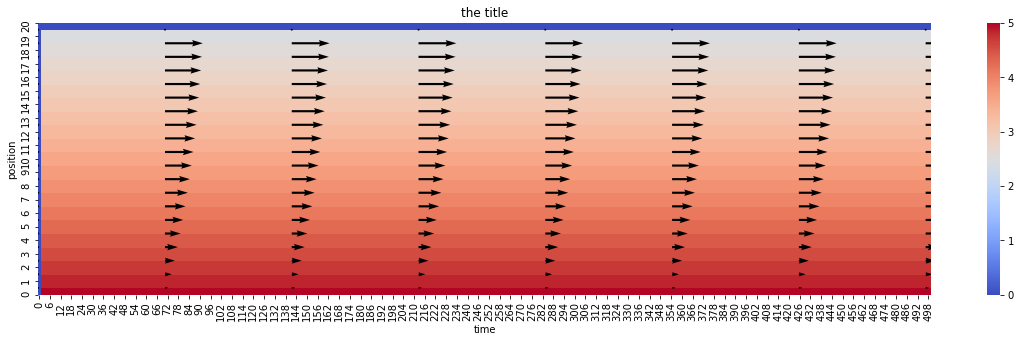

In [1]:
import context;
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import anabatic_flow_v8 as anfl;

### Case 1: Spin up from quiescent boundary conditions
Starting with zero initial wind velocity and 5 degree surface temperature anomaly, allow the model to reach steady state. We will match the initial/boundary conditions with those provided in (Zardi and Serafin) and specify resolutions to achieve numerical stability.

For the Forward in Time, Centered in Space (FTCS) scheme to remain stable:
$$
\Delta t < \frac{\Delta n^2}{2K}
$$
Note the quadratic dependence of the timestep on the space step, which means doubling the spatial resolution requires increasing the timestep by a factor of 4. This method is very expensive for high resolution simulations.

    dt: 0.04    
    tend: 500.0
    dn: 0.5
    nend: 80.
    
constants:

    g: 9.806
    Km: 3.
    Kh: 3.
    theta_0: 288
    gamma: 0.003
    beta: 30.
 
boundary conditions: 

    theta_surf: 5.
    theta_sky: 0.
    u_surf: 0.
    u_sky: 3.
    initvel: 0.
  

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

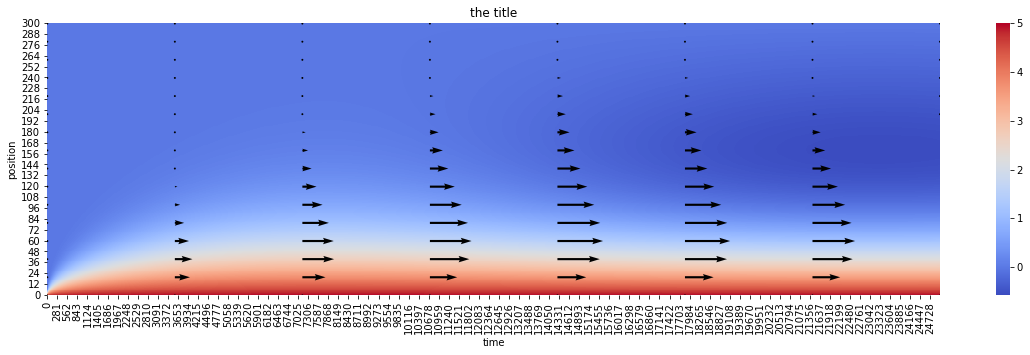

In [2]:
#Steady state, numerical sim
steady_state_num = anfl.Integrator('anabatic_spin_up.yaml','ftcs')
u_ss_num, theta_ss_num = steady_state_num.solve_eqns()
steady_state_num.make_plot(u_ss_num, theta_ss_num)

Now solve the equation analytically for the steady state so we can compare. Use the same initial conditions

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

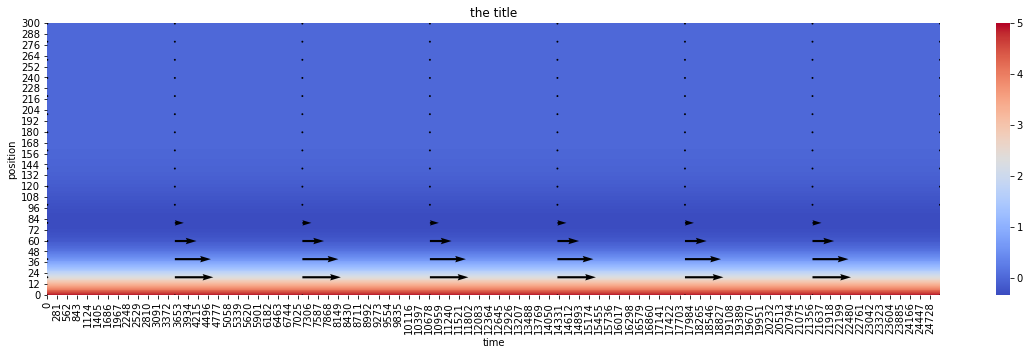

In [4]:
prandtl_exact = anfl.Integrator('anabatic_spin_up.yaml', 'ext_prandtl')
u_prandtl, theta_prandtl = prandtl_exact.solve_eqns()
prandtl_exact.make_plot(u_prandtl, theta_prandtl)

Lets examine the error associated with the numerical simulation. Subtract the exact fields from the simulated ones and plot the error.

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

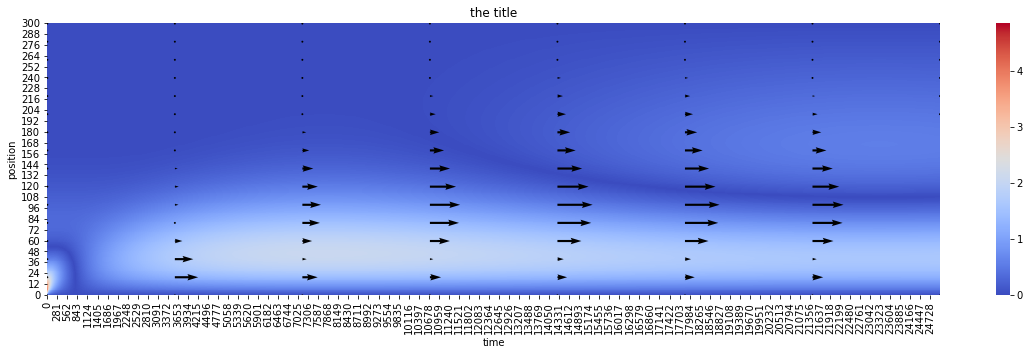

In [5]:
u_err = np.abs(u_prandtl - u_ss_num)
theta_err = np.abs(theta_prandtl - theta_ss_num)

prandtl_exact.make_plot(u_err, theta_err)

In [7]:
print(u_err[-1])

[0.00000000e+00 2.34485242e-01 4.48410293e-01 6.42494053e-01
 8.17452903e-01 9.73999551e-01 1.11284195e+00 1.23468229e+00
 1.34021604e+00 1.43013112e+00 1.50510700e+00 1.56581403e+00
 1.61291270e+00 1.64705302e+00 1.66887391e+00 1.67900272e+00
 1.67805469e+00 1.66663255e+00 1.64532614e+00 1.61471204e+00
 1.57535330e+00 1.52779916e+00 1.47258485e+00 1.41023136e+00
 1.34124536e+00 1.26611902e+00 1.18532998e+00 1.09934125e+00
 1.00860121e+00 9.13543601e-01 8.14587565e-01 7.12137680e-01
 6.06584039e-01 4.98302341e-01 3.87654008e-01 2.74986316e-01
 1.60632537e-01 4.49121134e-02 7.18691699e-02 1.89418990e-01
 3.07458281e-01 4.25721017e-01 5.43953987e-01 6.61916554e-01
 7.79380414e-01 8.96129342e-01 1.01195893e+00 1.12667632e+00
 1.24009995e+00 1.35205925e+00 1.46239438e+00 1.57095595e+00
 1.67760474e+00 1.78221138e+00 1.88465612e+00 1.98482849e+00
 2.08262703e+00 2.17795900e+00 2.27074012e+00 2.36089423e+00
 2.44835305e+00 2.53305589e+00 2.61494934e+00 2.69398704e+00
 2.77012937e+00 2.843343